In [1]:
println(VERSION, " (", Sys.CPU_NAME, ")")

1.7.2 (skylake)


In [2]:
println("[*] Checking runtime dependencies")
import Pkg
Pkg.activate(".")
Pkg.add("Unitful")
Pkg.add("DataStructures")
Pkg.add("Distributions")
Pkg.add("IterativeSolvers")
Pkg.add("Interpolations")
Pkg.add("ProgressMeter")
Pkg.add("SparseArrays")
Pkg.add("StaticArrays")
Pkg.resolve()

[*] Checking runtime dependencies


  Activating project at `~/iskra`
    Updating registry at `~/.julia/registries/General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`
   Resolving package versions...
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`
   Resolving package versions...
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`
   Resolving package versions...
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`
   Resolving package versions...
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`
   Resolving package versions...
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`
   Resolving package versions...
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`
   Resolving package versions...
  No Changes to `~/iskr

In [3]:
struct Config
  diagnostics
  solver
  pusher
  interactions
  species
  grid
end

In [4]:
# + units and constants
using Unitful
↦(value::Unitful.Units, unit::Unitful.Units) = Unitful.convfact(unit, value)
↦(value::Unitful.Quantity, unit::Unitful.Units) = uconvert(unit, value).val

# units
const °C = u"°C"
const K  = u"K"  ↦ u"K"
const kB = u"k"  ↦ u"J/K"
const C  = u"C"  ↦ u"C"
const V  = u"V"  ↦ u"V"
const m  = u"m"  ↦ u"m"
const cm = u"cm" ↦ u"m"
const u  = u"u"  ↦ u"kg"
const s  = u"s"  ↦ u"s"
const ms = u"ms" ↦ u"s"
const ns = u"ns" ↦ u"s"
const ps = u"ps" ↦ u"s"
const μs = u"μs" ↦ u"s"
const kV = u"MV" ↦ u"V"
const MV = u"MV" ↦ u"V"
const eV = u"eV" ↦ u"eV"
const kg = u"kg" ↦ u"kg"
const mps = u"m/s" ↦ u"m/s"
const kmps = u"km/s" ↦ u"m/s"
const kHz = u"kHz" ↦ u"Hz"
const MHz = u"MHz" ↦ u"Hz"

# constants
const ɛ0 = u"ɛ0" ↦ u"F/m"
const c0 = sqrt(u"1/ɛ0" * u"1/μ0") ↦ u"m/s"
const qe = 1.602_176_6208e-19C  # elementary charge
const me = 9.109_383_7015e-31kg # mass of electron
const mp = 1.672_621_8982e-27kg # mass of proton
nothing

In [5]:
function thermal_speed(T, m)
  sqrt(2kB*T/m)
end

thermal_speed (generic function with 1 method)

In [6]:
# + spatial and temporal paramters
const νtherm = thermal_speed(300K, me)
const νdrift = 1e7 #m/s
const mHe = 4.002602me/5.48579903e-04
const nHe = 1e24 # 1/m^3 number density
const ne = 1nHe
const f  = 9kHz # plasma frequency
const ω  = 2π * f * sqrt(2e-6ne)
const ds = 5e-3c0/ω
const ts = 1000
const nx = 256
const Δh = ds

const simulationVolume = nx * Δh
const numCells         = nx

const electronParticles    = 4 * numCells
const totalNumElectrons    = ne * simulationVolume
const electronNumRatio     = totalNumElectrons / electronParticles

Δt = .4Δh/νdrift/sqrt(2.0)
Lx = nx*Δh

println("Δt: ", Δt, "\nΔh: ", Δh, "\nLx: ", Lx)
println("νtherm: ", round(νtherm/c0; sigdigits=1), "c")
println("νdrift: ", round(νdrift/c0; sigdigits=3), "c")
println("electrons: ", electronParticles, " wg: ", electronNumRatio)

Δt: 5.30149462137438e-16
Δh: 1.8743613985989163e-8
Lx: 4.798365180413226e-6
νtherm: 0.0003c
νdrift: 0.0334c
electrons: 1024 wg: 4.685903496497291e15


In [7]:
using StaticArrays
include("ParticleInCell/src/pic/kinetic.jl");

In [8]:
# + species and sources
const e   = KineticSpecies{1,3}("e-",  20_000, -1qe, 1me,  electronNumRatio)
const iHe = KineticSpecies{1,3}("He+", 20_000, +1qe, 1mHe, electronNumRatio)

include("ParticleInCell/src/pic/sources.jl")
const fwd = MaxwellianSource{1,3}(electronParticles/2/Δt, [Lx,], [νtherm,νtherm,νtherm], dv=[+νdrift,0.,0.])
const rev = MaxwellianSource{1,3}(electronParticles/2/Δt, [Lx,], [νtherm,νtherm,νtherm], dv=[-νdrift,0.,0.])

const species = [e, iHe]

2-element Vector{KineticSpecies{1, 3}}:
 e-
 He+

In [9]:
using LinearAlgebra
using Statistics
using SparseArrays
include("pole/boundary_conditions.jl")
include("pole/gradient.jl")
include("pole/iterative_methods.jl")
include("pole/inplace_periodic_solver.jl")
include("pole/linear_solver.jl")
include("pole/linear_solver1.jl")

solution(ps::InPlacePeriodicSolver) = ps.u
gradient(ps::InPlacePeriodicSolver) = let periodic = PeriodicBC()
    GradientOperator(ps.nx, ps.δx, (periodic, periodic))
end

solution(ps::LinearSolver) = reshape(ps.u, ps.n...)
gradient(ps::LinearSolver) = GradientOperator(ps.n[1], ps.δ[1], ps.bcs)

function create_poisson_solver(grid, ε0)
    xf, = grid.coords
    ps = LinearSolver(xf; left=PeriodicBC(), right=PeriodicBC())
    #ps = InPlacePeriodicSolver(xf; maxiter=5000)
end

function calculate_electric_potential(ps, f)
    @inbounds for i in eachindex(f)
      f[i] /= ε0
    end
    solve!(ps, f)
    φ  = solution(ps)
    #φ.-= mean(φ)
end

calculate_electric_potential (generic function with 1 method)

In [10]:
using LinearAlgebra, StaticArrays
const xs = 0m:Δh:Lx
include("RegularGrids/src/uniform_grid.jl")
include("ParticleInCell/src/pic/pushers.jl")
const grid    = create_uniform_grid(xs)
const solver  = create_poisson_solver(grid, ε0)
const pusher  = create_boris_pusher(species)
nothing

In [11]:
include("ParticleInCell/src/pic/wrap.jl")
function after_push(part, grid)
  wrap!(part, grid)
end

function enter_loop() # uses global: e, iHe, fwd, rev
  e.np = 0
  sample!(fwd, e, Δt)
  sample!(rev, e, Δt)
  # place ions in the same positions as electrons
  iHe.x .= e.x
  iHe.v .= zero(e.v)
  iHe.np = e.np
end

function iteration(i, t, dt) # uses global: e
  ((:iteration, i), (:e, e.np))
end

iteration (generic function with 1 method)

In [12]:
using Random; Random.seed!(0)

using ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
const progress = Progress(ts)

function after_loop(i, t, dt) # uses global: progress
  update!(progress, i; showvalues = iteration(i, t, dt))
end

function exit_loop() end

const diagnostics = Dict{String, Array{Float64, 2}}(
    "ne-"  => zeros(nx, ts),
    "nHe+" => zeros(nx, ts),
    "rho"  => zeros(nx, ts),
    "phi"  => zeros(nx, ts),
    "Ex"   => zeros(nx+1, ts))

const config = Config(diagnostics, solver, pusher, [], species, grid)
println("[*] Running simulation")

struct FluidSpecies end
include("ParticleInCell/src/pic/algorithm.jl")
include("ParticleInCell/src/pic/cloud_in_cell.jl")
@time solve(config, Δt, 5)
@time solve(config, Δt, ts)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
  iteration:  1000
  e:          1024


Complete!
  0.530443 seconds (8.38 M allocations: 430.108 MiB, 10.36% gc time, 10.84% compilation time)


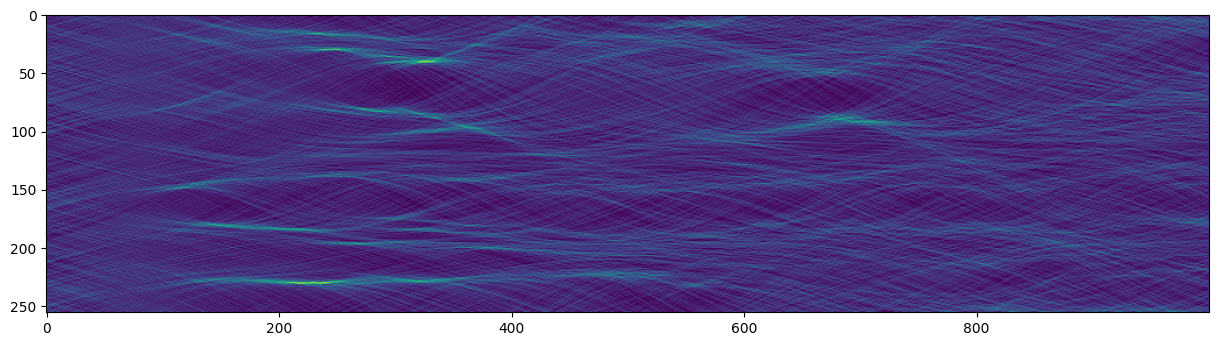

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/bach/.julia/packages/PyPlot/XaELc/src/init.jl:198


PyObject <matplotlib.image.AxesImage object at 0x7f9b914a7d90>

In [13]:
import PyPlot
PyPlot.figure(figsize=(15, 6))
PyPlot.imshow(diagnostics["ne-"])

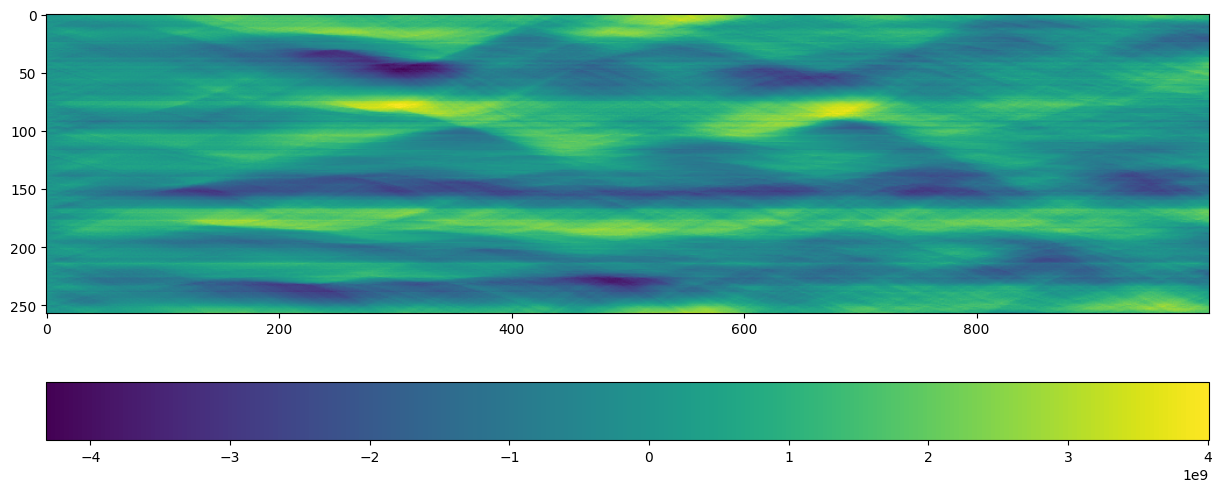

In [14]:
import PyPlot
PyPlot.figure(figsize=(15, 6))
PyPlot.imshow(diagnostics["Ex"])
PyPlot.colorbar(orientation="horizontal");